# Laboratorio 7 (Aprendizaje por refuerzo) Grupo 1
 <h3>Implementacion incremental<h3>
 <HR>
 <h3>
  NOMBRES:
  
  * POLO ORELLANA BRAYAN SIMON
  * LOPEZ CHIRI DIMAR GABRIEL
  
  <br>
  CARRERA: INGENIERIA DE SISTEMAS
  <BR>
  FECHA: 17/06/2024 <BR>

  * [Enlace de invitacion para ser colaborador](https://github.com/bspoloo/SIS420-012024/invitations)
  
  * [Enlace al git hub](https://github.com/bspoloo/SIS420-012024/tree/main/Laboratorios/Laboratorio%207)

 <h3>

# Seleccion de acciones con intervalo de confianza
es una mejora del enfoque $\epsilon$-greedy para la exploración en algoritmos de aprendizaje por refuerzo, especialmente útil en entornos donde es importante balancear la exploración (buscar nuevas acciones que puedan tener un alto retorno en el futuro) y la explotación (tomar acciones conocidas que han dado buenos resultados previamente).
$$
    A_t = \underset{a}{\arg\max} \, \left[ Q_t(a) + c \sqrt{\frac{\text{ln} \, t}{N_t(a)}} \right]
$$

mejora la exploración en comparación con el enfoque estándar $\epsilon$-greedy, ya que considera tanto la estimación actual de la acción como su historial de selecciones. Esto permite al agente explorar de manera más eficiente, priorizando las acciones menos exploradas que aún tienen potencial para generar recompensas altas, mientras explota las acciones conocidas que han demostrado ser efectivas en el pasado.

## Importacion librerias
importamos las librerias necesarias para la realizacion de este laboratorio:

In [52]:
#Importamos la librería gym para poder utilizar el entorno de OpenAI
import gymnasium as gym
#Importamos la librería numpy para poder trabajar con arrays
import numpy as np
#Importamos la librería matplotlib para poder realizar gráficas
import matplotlib.pyplot as plt 
#Importamos la librería os para poder interactuar con el sistema operativo
import os
#Importamos la función clear_output de la librería IPython.display para poder limpiar la salida de la celda
from IPython.display import clear_output
#Importamos la librería random para poder generar números aleatorios 
import random
#Importamos la librería matplotlib para poder realizar gráficas 
import matplotlib.pyplot as plt
#Importamos la librería pickle para poder guardar los datos en un archivo 
import pickle
#Importamos la librería time para poder utilizar la función sleep
import time
#Importamos la librería pandas para poder trabajar con dataframes 
import pandas as pd

## Creacion de funcion para graficar las recompensas acumuladas cada episodio
Esta Clase tien la funcion de graficar, el cual toma los parametros de premios por episodio, el numero de episodios:

In [54]:

def Graphic_Average_reward_per_epsilon(reward_per_epsilon, epsilons):
    plt.figure(figsize=(8, 5))
    for epsilon in epsilons:
        plt.plot(reward_per_epsilon[epsilon], label=f'$\epsilon$ = {epsilon}')
    plt.legend()
    plt.grid(True)
    plt.xlabel('Episodios')
    plt.ylabel('Recompensa media')
    plt.title('Recompensa media por episodio para diferentes valores de $\epsilon$')
    plt.show()

<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:27: SyntaxWarning: invalid escape sequence '\e'
<>:32: SyntaxWarning: invalid escape sequence '\e'
<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:27: SyntaxWarning: invalid escape sequence '\e'
<>:32: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ANIMETX\AppData\Local\Temp\ipykernel_12180\1449826397.py:14: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(sum_rewards, label=f'$\epsilon$ = {epsilon}')
C:\Users\ANIMETX\AppData\Local\Temp\ipykernel_12180\1449826397.py:27: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(reward_per_epsilon[epsilon], label=f'$\epsilon$ = {epsilon}')
C:\Users\ANIMETX\AppData\Local\Temp\ipykernel_12180\1449826397.py:32: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Recompensa media por episodio para diferentes valores de $\epsilon$')


## Implementacion del Modelo
Para este modelo se crearon dos clases, el `Game` y `Agente`, esto para tener el codigo mas entendible y mas ordenado:

### Game
La clase `Game` contiene sus atributos y metodos, donde nos ayudaran a interactuar con el agente y su entorno para la **exploracion**, **explotacion**, importacion y explotacion del ``agente``:

**Parametros:**
- Agente: esta es la clase principal el cual contiene el entorno, este entorno es el que contiene espacio de estados y un espacio de acciones para que un agente interactúe con él
- Explore: este parametro nos sirve para verifcar que el entorno actual es de exploracion o explotacion, ``False`` y ``True``

**Metodos:**
- is_explore(): esta funcion valida que el agente este en modo exploracion o explotacion:
    * Exploracion: Si el agente esta en modo exploracion inicia la tabla `q` y `actions` del agente en vacio
    * Explotacion: Si el agente esta en modo explotacion caragara el archivo `.pkl` donde esta almacenada una tabla de una exploracion anteriro
- run(): este es el metodo mas importante de la clase `Game`, ya que toma el numero de episodios y ejecuta cada episodo, esta es la parte donde el agente en verdad aprende.

In [55]:
class Game():
    def __init__(self, Agent, explore=True):
        self.agent = Agent
        self.explore = explore
        self.is_explore()

    def is_explore(self):
        if self.explore:
            self.agent.q = np.zeros((self.agent.env.observation_space.n, self.agent.env.action_space.n))
        else:
            self.agent.load_pickle()

    def run(self, episodes=100):
        RENDER_AT_EPISODE = 1
        rewards_per_episode = np.zeros(episodes)
        
        for episode in range(episodes):
            state = self.agent.reset()
            episode_reward = 0
            
            while True:
                action = self.agent.choose_action(state, self.explore)
                print(f"State {state} Action: {action}")
                next_state, reward, terminated, truncated, _ = self.agent.env.step(action)
                
                done = terminated or truncated 
                if self.explore:
                    self.agent.learn(state, action, reward, next_state, done)
                
                state = next_state
                episode_reward += reward
            
                if done:
                    break
        
            if episode % RENDER_AT_EPISODE == 0:
                clear_output(wait=True)
                self.agent.env.render()
            # self.agent.epsilon = max(self.agent.epsilon - self.agent.epsilon_decay_rate, 0.01)
            rewards_per_episode[episode] = episode_reward
            print(f"Episode {episode}/{episodes}, Epsilon: {self.agent.epsilon:.4f}, Reward: {episode_reward:.4f}")
        self.agent.save_pickle()
        self.agent.env.close()
        return rewards_per_episode

### Agente
Esta clase tiene es nuestro agente, el que interactua con el entorno del juego, el que toma las acciones:

- Hyperparametros:
    * epsilon:  $\epsilon$ es un parámetro crucial en las políticas de aprendizaje por refuerzo, permitiendo al agente equilibrar la exploración y la explotación para aprender de manera eficiente en un entorno dinámico.
    * alpha: $\alpha$ (alpha) es el parámetro de tasa de aprendizaje (learning rate). Este parámetro controla cuánto se actualizan los valores en la tabla Q o la función de valor en cada paso de aprendizaje.
    * gamma: En el contexto del aprendizaje por refuerzo (Reinforcement Learning, RL), $\gamma$ (gamma) es el parámetro del factor de descuento (discount factor). Este parámetro determina la importancia de las recompensas futuras en la toma de decisiones del agente.
    * c:  donde $c > 0$ es una constante que controla el ratio de exploración.

- Variables del Agente:
    * url_pickle: Ruta para guardar o cargar la tabla Q en un archivo pickle.
    * episode_reward: Recompensa acumulada por episodio.
    * env: El entorno en el que opera el agente.
    * q: La tabla Q que almacena los valores de Q para cada estado-acción.
    * action_counts: Cuenta de cuántas veces se ha tomado cada acción en cada estado.

- Explicación Adicional
    * reset: Restablece el entorno y devuelve el estado inicial.
    * upper_confidence_bound: este metodo aplica el UCB
    * select_best_action: Selecciona la mejor acción posible en un estado dado basado en los valores Q actuales.
    * choose_action: Elige una acción basada en la política $\epsilon$-greedy.
    * learn: Actualiza los valores de la tabla Q utilizando la fórmula de Q-learning.
    * save_pickle: Guarda la tabla Q en un archivo.
    * load_pickle: Carga la tabla Q desde un archivo.

In [56]:
class Agent():
    def __init__(self,env ,epsilon, alpha=0.01, gamma=0.99, c= 1):
        #hiperparametros
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.c = c
        #variables
        self.url_pickle = f"CliffWalking{self.epsilon}.pkl"
        self.episode_reward = 0
        self.env = env
        self.q = np.zeros((env.observation_space.n, env.action_space.n))
        self.action_counts = np.zeros((env.observation_space.n, env.action_space.n))
        self.total_steps = 0
    
    def reset(self):
        return self.env.reset()[0]
    
    def upper_confidence_bound(self, state):
        print("UCB")
        ucb_values = self.q[state] + self.c * np.sqrt(np.log(self.total_steps) / (self.action_counts[state] + 1e-5))
        return np.argmax(ucb_values)
    
    def select_best_action(self, explore, state):
        max_q = np.max(self.q[state, :])
        actions = np.where(self.q[state, :] == max_q)[0]
        return np.random.choice(actions)

    def choose_action(self, state, explore):
        self.total_steps += 1
        if explore and self.epsilon == 0:
            print("haciendo UCB")
            return self.upper_confidence_bound(state)
        else:
            if explore and np.random.uniform(0, 1) < self.epsilon:
                return self.env.action_space.sample()
            else:
                return self.select_best_action(explore, state)

    def learn(self, state, action, reward, next_state, done):
        best_next_action = np.argmax(self.q[next_state])
        td_target = reward + self.gamma * self.q[next_state, best_next_action] * (not done)
        self.q[state, action] += self.alpha * (td_target - self.q[state, action])
        self.action_counts[state, action] += 1

    def save_pickle(self):
            with open(self.url_pickle, "wb") as f:
                pickle.dump(self.q, f)

    def load_pickle(self):
        print("Loading pickle")
        with open(self.url_pickle, 'rb') as f:
            self.q = pickle.load(f)
            self.action_counts = np.zeros(self.env.action_space.n)

## Exploracion del agente
La exploracion del agente consiste en probar diferentes acciones para descubrir cuáles resultan en las mejores recompensas a largo plazo. Es un componente crucial en la estrategia de aprendizaje porque permite al agente evitar quedarse atrapado en una solución subóptima que puede parecer buena en el corto plazo pero no lo es a largo plazo.

En esta parte haremos que diferentes agentes con diferentes valores de epsilon, exploren el entorno del `CliffWalking`, y almacenaremos las recompensas por episodio para luego mostrarlas en una grafica para ver el comportamiento de del agente a lo largo de los episodio.

In [61]:
epsilons = [0,1]
average_reward_per_epsilon = {}
reward_per_episode = {}
games = {}

render = False
env = gym.make('CliffWalking-v0', render_mode="human" if render else None)

for epsilon in epsilons:
    agent = Agent(env ,epsilon)
    game = Game(agent, explore=True)
    games[epsilon] = game

for epsilon, game in games.items():
    episodes = 100
    reward_per_episode[epsilon] = game.run(episodes)
    average_reward_per_epsilon[epsilon] =  reward_per_episode[epsilon]/ episodes

Episode 99/100, Epsilon: 1.0000, Reward: -113872.0000


Final average reward for epsilon=0: -18353.08
Final average reward for epsilon=1: -2907881.92


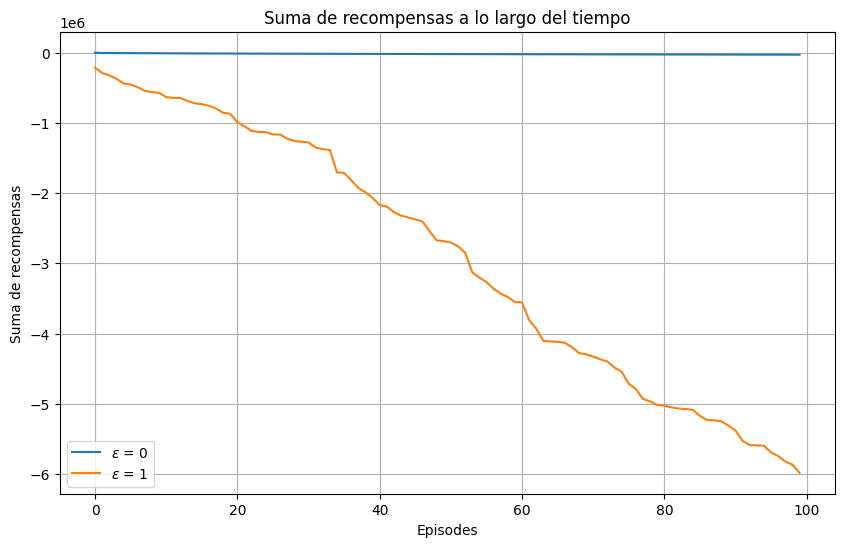

In [62]:
graphic.Graphic_reward_per_episode(reward_per_episode, episodes, epsilons)

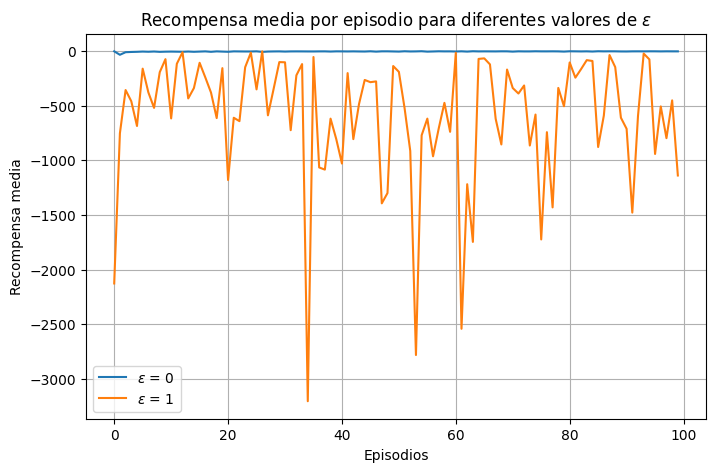

In [63]:
graphic.Graphic_reward_per_epsilon(reward_per_epsilon, epsilons)

In [ ]:
render = True
explore = False
epsilon = 1
env = gym.make('CliffWalking-v0', render_mode="human" if render else None)
agent = Agent(env, epsilon)
game = Game(agent, explore=explore)
game.run(2)

0: Move up

1: Move right

2: Move down

3: Move left

In [68]:
q_df = pd.DataFrame(games[0].agent.q)
print("Q-table as DataFrame:")
q_df

Q-table as DataFrame:


,0,1,2,3
0,-2.311488,-2.304900,-2.322552,-2.311488
1,-2.251093,-2.246830,-2.247933,-2.255401
2,-2.162000,-2.151219,-2.164306,-2.162380
3,-2.044269,-2.041116,-2.044285,-2.054242
4,-1.926544,-1.917761,-1.930051,-1.935789
5,-1.798993,-1.788725,-1.802227,-1.814466
6,-1.661689,-1.659939,-1.664504,-1.678973
7,-1.534049,-1.523575,-1.535229,-1.543246
8,-1.387011,-1.382441,-1.394606,-1.406675
9,-1.249798,-1.238769,-1.252017,-1.266318


: 